<img src="https://gitlab.inf.unibz.it/earth_observation_public/eurac-openeo-examples/-/raw/main/python/aux_data/eurac_EO.png"
     alt="EURAC EO logo"
     style="float: left; margin-right: 10px; max-width: 300px" />

<img src="https://avatars.githubusercontent.com/u/63704085?s=400&u=5dc6c45b7d457ce6f303fbc612091cb2c133482f&v=4"
     alt="SAR2Cube logo"
     style="float: right; max-width: 200px" />
## SAR2Cube and openEO - Computing SAR Interferometric Coherence on-the-fly with a boxcar filter
### Author michele.claus@eurac.edu
### Date: 2023/01/09

## Useful links:

SAR2Cube website: https://sar2cube.projects.eurac.edu/

openEO main website: https://openeo.org/

openEO Python Client documentation: https://open-eo.github.io/openeo-python-client/index.html

Getting started guide for openEO with python: https://openeo.org/documentation/1.0/python/

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import openeo
from openeo.processes import *
from openeo.rest.datacube import PGNode, THIS

### Connect and login

In [2]:
openeoHost = "https://openeo.eurac.edu"
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")

Authenticated using refresh token.


Please check to have the latest openeo library. openeo >= 0.12.0 is required

In [3]:
openeo.__version__

'0.12.0'

## Doñana Datacubes:
Sentinel-1:
```
SAR2Cube_SInCohMap_S1_L0_147_ASC_DONYANA
SAR2Cube_SInCohMap_S1_L0_154_DSC_DONYANA
```
Sentinel-2:
```
SInCohMap_S2_L1C_T29SQB
```
## South Tyrol Datacubes
Sentinel-1:
```
SAR2Cube_SInCohMap_S1_L0_117_ASC_SOUTH_TYROL
SAR2Cube_SInCohMap_S1_L0_168_DSC_SOUTH_TYROL
```
Sentinel-2:
```
S2_L1C_T32TPS
```
## Finland Datacubes
Sentinel-1:
```
SAR2Cube_SInCohMap_S1_L0_80_DSC_FINLAND_AOI1
SAR2Cube_SInCohMap_S1_L0_80_DSC_FINLAND_AOI2
```

# Coherence


Firstly download a tiny subset of the datacube for the whole timeseries.
With the downloaded netCDF we can extract the available dates and compute the master-slave pairs for the given temporal baseline.

**Please note: this step is not necessary since sample netCDFs with the vailable dates are already provided in the GitHub repo in the aux_data folder.**

The available netCDFs containing the dates for the SInCohMap Sentinel-1 datacubes are:
```
./aux_data/Donyana_ASC_147_dates.nc
./aux_data/Donyana_DSC_154_dates.nc
./aux_data/Finland_AOI1_dates.nc
./aux_data/Finland_AOI1_dates.nc
./aux_data/South_Tyrol_DSC_168_dates.nc
./aux_data/South_Tyrol_ASC_117_dates.nc
```

In [4]:
# conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")
# spatial_extent  = {'west':-6.094129 ,'east':-6.091833 ,'south':37.115613 ,'north':37.117239}
# collection      = 'SAR2Cube_SInCohMap_S1_L0_147_ASC_DONYANA'
# # Not specifying the temporal extent will load the whole timeseries
# bands = ['grid_lon','grid_lat']
# S1_slant_range = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands)

In [5]:
# %%time
# S1_slant_range.download('./aux_data/Donyana_ASC_147_dates.nc')

## AOI
We usa a sample AOI over Doñana, Spain

In [6]:
spatial_extent = {'west': -6.31,'east': -5.87,'south': 37.05,'north': 37.19}

Compute the master-slave pairs for the given temporal baseline.

Read the retrieved netCDF containing the timestamps:

In [7]:
dates_netcdf = xr.open_dataarray('./aux_data/Donyana_ASC_147_dates.nc')
dates_netcdf.time

<xarray.DataArray 'time' (time: 181)>
array(['2017-01-02T23:59:59.000000000', '2017-01-08T23:59:59.000000000',
       '2017-01-14T23:59:59.000000000', '2017-01-20T23:59:59.000000000',
       '2017-01-26T23:59:59.000000000', '2017-02-01T23:59:59.000000000',
       '2017-02-07T23:59:59.000000000', '2017-02-13T23:59:59.000000000',
       '2017-02-19T23:59:59.000000000', '2017-02-25T23:59:59.000000000',
       '2017-03-03T23:59:59.000000000', '2017-03-09T23:59:59.000000000',
       '2017-03-15T23:59:59.000000000', '2017-03-21T23:59:59.000000000',
       '2017-04-02T23:59:59.000000000', '2017-04-08T23:59:59.000000000',
       '2017-04-14T23:59:59.000000000', '2017-04-20T23:59:59.000000000',
       '2017-04-26T23:59:59.000000000', '2017-05-02T23:59:59.000000000',
       '2017-05-08T23:59:59.000000000', '2017-05-14T23:59:59.000000000',
       '2017-05-20T23:59:59.000000000', '2017-05-26T23:59:59.000000000',
       '2017-06-01T23:59:59.000000000', '2017-06-07T23:59:59.000000000',
       '2017-06-13T23:59:59.000000000', '2017-06-19T23:59:59.000000000',
       '2017-06-25T23:59:59.000000000', '2017-07-01T23:59:59.000000000',
       '2017-07-07T23:59:59.000000000', '2017-07-13T23:59:59.000000000',
       '2017-07-19T23:59:59.000000000', '2017-07-25T23:59:59.000000000',
       '2017-07-31T23:59:59.000000000', '2017-08-06T23:59:59.000000000',
       '2017-08-12T23:59:59.000000000', '2017-08-18T23:59:59.000000000',
       '2017-08-24T23:59:59.000000000', '2017-08-30T23:59:59.000000000',
       '2017-09-05T23:59:59.000000000', '2017-09-11T23:59:59.000000000',
       '2017-09-17T23:59:59.000000000', '2017-09-23T23:59:59.000000000',
       '2017-09-29T23:59:59.000000000', '2017-10-05T23:59:59.000000000',
       '2017-10-11T23:59:59.000000000', '2017-10-17T23:59:59.000000000',
       '2017-10-23T23:59:59.000000000', '2017-10-29T23:59:59.000000000',
       '2017-11-04T23:59:59.000000000', '2017-11-10T23:59:59.000000000',
       '2017-11-16T23:59:59.000000000', '2017-11-22T23:59:59.000000000',
       '2017-11-28T23:59:59.000000000', '2017-12-04T23:59:59.000000000',
       '2017-12-10T23:59:59.000000000', '2017-12-16T23:59:59.000000000',
       '2017-12-22T23:59:59.000000000', '2017-12-28T23:59:59.000000000',
       '2018-01-03T23:59:59.000000000', '2018-01-09T23:59:59.000000000',
       '2018-01-15T23:59:59.000000000', '2018-01-21T23:59:59.000000000',
       '2018-01-27T23:59:59.000000000', '2018-02-02T23:59:59.000000000',
       '2018-02-08T23:59:59.000000000', '2018-02-14T23:59:59.000000000',
       '2018-02-20T23:59:59.000000000', '2018-02-26T23:59:59.000000000',
       '2018-03-04T23:59:59.000000000', '2018-03-10T23:59:59.000000000',
       '2018-03-16T23:59:59.000000000', '2018-03-22T23:59:59.000000000',
       '2018-03-28T23:59:59.000000000', '2018-04-03T23:59:59.000000000',
       '2018-04-09T23:59:59.000000000', '2018-04-15T23:59:59.000000000',
       '2018-04-21T23:59:59.000000000', '2018-04-27T23:59:59.000000000',
       '2018-05-03T23:59:59.000000000', '2018-05-09T23:59:59.000000000',
       '2018-05-15T23:59:59.000000000', '2018-05-21T23:59:59.000000000',
       '2018-05-27T23:59:59.000000000', '2018-06-02T23:59:59.000000000',
       '2018-06-08T23:59:59.000000000', '2018-06-14T23:59:59.000000000',
       '2018-06-26T23:59:59.000000000', '2018-07-02T23:59:59.000000000',
       '2018-07-08T23:59:59.000000000', '2018-07-14T23:59:59.000000000',
       '2018-07-20T23:59:59.000000000', '2018-07-26T23:59:59.000000000',
       '2018-08-01T23:59:59.000000000', '2018-08-07T23:59:59.000000000',
       '2018-08-13T23:59:59.000000000', '2018-08-19T23:59:59.000000000',
       '2018-08-25T23:59:59.000000000', '2018-08-31T23:59:59.000000000',
       '2018-09-06T23:59:59.000000000', '2018-09-12T23:59:59.000000000',
       '2018-09-18T23:59:59.000000000', '2018-09-24T23:59:59.000000000',
       '2018-09-30T23:59:59.000000000', '2018-10-06T23:59:59.000000000',
       '2018-10-12T23:59:59.000000000', '2018-10-18T23:59:59.000000000',
       '2018-10-24T2

Coherence temporal baseline

In [8]:
timedelta = 6

We want to compute the coherence for a pair of dates in January 2018. (Please try a small temporal extent firstly)

In [10]:
timesteps = dates_netcdf['time'].loc[dict(time=slice('2018-01-27','2018-02-03'))].values
print("First date available: ",timesteps[0])
print("Last date available:  ",timesteps[-1])

First date available:  2018-01-27T23:59:59.000000000
Last date available:   2018-02-02T23:59:59.000000000


We loop through the timesteps and check where we have 6 or 12 or ... days pairs of dates

In [11]:
dates_pair = []
for i,t in enumerate(timesteps[:-1]):
    for t2 in timesteps[i+1:]:
        if(np.timedelta64(t2 - t, 'D')) == np.timedelta64(timedelta,'D'):
            dates_pair.append([t,t2])
print("First date pair: ",dates_pair[0])
print("Last date pair:  ",dates_pair[-1])

First date pair:  [numpy.datetime64('2018-01-27T23:59:59.000000000'), numpy.datetime64('2018-02-02T23:59:59.000000000')]
Last date pair:   [numpy.datetime64('2018-01-27T23:59:59.000000000'), numpy.datetime64('2018-02-02T23:59:59.000000000')]


We define new temporal labels containing the master and slave dates:

In [12]:
mst_slv_temporal_labels = [ str(i[0])[:10] + "_" + str(i[1])[:10] for i in dates_pair]
mst_slv_temporal_labels.reverse()
print("The output will have a temporal label named like this: ",mst_slv_temporal_labels[0])

The output will have a temporal label named like this:  2018-01-27_2018-02-02


We now got the master-slave date pairs which will be used to compute the coherence.

Now we define the utility functions for computing the complex coherence and then its amplitude

In [13]:
def compute_real_part_numerator_VH(x:ProcessBuilder):
    i_mst = array_element(x,label='i_VH_mst')
    q_mst = array_element(x,label='q_VH_mst')
    i_slv = array_element(x,label='i_VH_slv')
    q_slv = array_element(x,label='q_VH_slv')
    return (i_mst*i_slv + q_mst*q_slv)

def compute_imag_part_numerator_VH(x:ProcessBuilder):
    i_mst = array_element(x,label='i_VH_mst')
    q_mst = array_element(x,label='q_VH_mst')
    i_slv = array_element(x,label='i_VH_slv')
    q_slv = array_element(x,label='q_VH_slv')
    return (q_mst*i_slv - i_mst*q_slv)

def compute_mst_denominator_VH(x:ProcessBuilder):
    i_mst = array_element(x,label='i_VH_mst')
    q_mst = array_element(x,label='q_VH_mst')
    return (i_mst**2+q_mst**2)

def compute_slv_denominator_VH(x:ProcessBuilder):
    i_slv = array_element(x,label='i_VH_slv')
    q_slv = array_element(x,label='q_VH_slv')
    return (i_slv**2+q_slv**2)

def compute_coherence_amplitude_VH(x:ProcessBuilder):
    q_num_VH = array_element(x,label='q_num_VH')
    i_num_VH = array_element(x,label='i_num_VH')
    mst_den = array_element(x,label='mst_den')
    slv_den = array_element(x,label='slv_den')
    
    coh_i = i_num_VH / ((mst_den * slv_den + 1e-12)**0.5)
    coh_q = q_num_VH / ((mst_den * slv_den + 1e-12)**0.5)
    
    return (coh_i**2+coh_q**2)**0.5

Coherence parameters:

In [14]:
# Boxcar filter
range_dim   = 19
azimuth_dim = 4

# Geocoding
resolution = 10 # can be 10, 20 or 60 meters, it will be aligned with the Sentinel-2 grid
crs = 32629

# Datacube
collection = 'SAR2Cube_SInCohMap_S1_L0_147_ASC_DONYANA'

In [23]:
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")
bands = ['grid_lon','grid_lat','i_VH','q_VH']
S1_slant_range = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands)

# We use a loop over the dates we want to request and a combination of filter_temporal + merge_cubes to get only the dates we want:
for i,date_pair in enumerate(dates_pair):
    # The requested date until the day after, since openEO excludes the end date
    mst_date = date_pair[0]
    slv_date = date_pair[1]
    mst_temporal_extent = [str(mst_date),str(mst_date + np.timedelta64(1, 'D'))]
    slv_temporal_extent = [str(slv_date),str(slv_date + np.timedelta64(1, 'D'))]

    if i == 0:
        S1_slant_range_mst_bands = S1_slant_range.filter_temporal(mst_temporal_extent)
        S1_slant_range_slv_bands = S1_slant_range.filter_temporal(slv_temporal_extent)
    else:
        S1_slant_range_mst_bands = S1_slant_range.filter_temporal(mst_temporal_extent).merge_cubes(S1_slant_range_mst_bands)
        S1_slant_range_slv_bands = S1_slant_range.filter_temporal(slv_temporal_extent).merge_cubes(S1_slant_range_slv_bands)

Authenticated using refresh token.


In [24]:
S1_slant_range_mst_bands = S1_slant_range_mst_bands.filter_bands(['i_VH','q_VH'])
S1_slant_range_slv_bands = S1_slant_range_slv_bands.filter_bands(['i_VH','q_VH'])

We rename the temporal labels to facilitate the next steps of the coherence computation:

In [25]:
# We need to call rename_labels in this way because calling it directly as we do for the bands returns an error for the temporal dimension
args_rename_labels = {'data': THIS,'dimension':'DATE','target':mst_slv_temporal_labels}

S1_slant_range_mst_bands = S1_slant_range_mst_bands.process('rename_labels',args_rename_labels)
S1_slant_range_slv_bands = S1_slant_range_slv_bands.process('rename_labels',args_rename_labels)

We rename the bands according to the master/slave members

In [26]:
S1_slant_range_mst_bands = S1_slant_range_mst_bands.rename_labels(dimension='bands',
                                                                  source=['i_VH','q_VH'],
                                                                  target=['i_VH_mst','q_VH_mst'])
S1_slant_range_slv_bands = S1_slant_range_slv_bands.rename_labels(dimension='bands',
                                                                  source=['i_VH','q_VH'],
                                                                  target=['i_VH_slv','q_VH_slv'])

Merge the two datacubes into a single one

In [27]:
S1_slant_range_mst_slv_bands = S1_slant_range_mst_bands.merge_cubes(S1_slant_range_slv_bands)

Compute the coherence numerator for VH

In [28]:
i_numerator_VH = S1_slant_range_mst_slv_bands.reduce_dimension(dimension='bands',
                                                               reducer=compute_real_part_numerator_VH)
q_numerator_VH = S1_slant_range_mst_slv_bands.reduce_dimension(dimension='bands',
                                                               reducer=compute_imag_part_numerator_VH)

Compute the coherence denominator

In [29]:
mst_denominator_VH = S1_slant_range_mst_slv_bands.reduce_dimension(dimension='bands',
                                                                   reducer=compute_mst_denominator_VH)
slv_denominator_VH = S1_slant_range_mst_slv_bands.reduce_dimension(dimension='bands',
                                                                   reducer=compute_slv_denominator_VH)

Merge all the bands

In [30]:
i_numerator_VH_with_dim = i_numerator_VH.add_dimension(type='bands',name='bands',label='i_num_VH')
q_numerator_VH_with_dim = q_numerator_VH.add_dimension(type='bands',name='bands',label='q_num_VH')
mst_denominator_VH_with_dim = mst_denominator_VH.add_dimension(type='bands',name='bands',label='mst_den')
slv_denominator_VH_with_dim = slv_denominator_VH.add_dimension(type='bands',name='bands',label='slv_den')

coh_numerator_denominator_VH = i_numerator_VH_with_dim.merge_cubes(q_numerator_VH_with_dim).merge_cubes(mst_denominator_VH_with_dim).merge_cubes(slv_denominator_VH_with_dim)

Apply boxcar filter

In [33]:
kernel = np.ones((range_dim,azimuth_dim))
coh_numerator_denominator_VH_boxcar = coh_numerator_denominator_VH.apply_kernel(kernel=kernel,
                                                                                factor=1/(range_dim*azimuth_dim),
                                                                                border='reflect')

Compute the coherence amplitude

In [35]:
coh_VH = coh_numerator_denominator_VH_boxcar.reduce_dimension(dimension='bands',
                                                              reducer=compute_coherence_amplitude_VH)
coh_amplitude = coh_VH.add_dimension(name='bands',
                              label='coh_vh_amp')

Geocoding

In [36]:
lat_lon_grids = S1_slant_range.filter_bands(['grid_lon','grid_lat']).reduce_dimension(dimension='DATE',
                                                                                      reducer=mean)
coh_amplitude = coh_amplitude.merge_cubes(lat_lon_grids)

args_geocoding = {'resolution':resolution,'crs':crs}
coh_amplitude_geocoded = coh_amplitude.process('geocode',args_geocoding, data=coh_amplitude).reduce_dimension(dimension='DATE',reducer=mean)

coh_amplitude_geocoded_tif = coh_amplitude_geocoded.save_result(format='GTIFF')

In [37]:
job = conn.create_job(coh_amplitude_geocoded_tif,title="SAR2CUBE_coherence_Donyana_ASC_boxcar_10m")
job_id = job.job_id
if job_id:
    print("Batch job created with id: ",job_id)
    job.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  bb470f17-0fa5-4611-b19b-18e2d8631a9b


In [42]:
job

<BatchJob job_id='bb470f17-0fa5-4611-b19b-18e2d8631a9b'>

Download all the results if all the jobs have been completed

In [48]:
import os
result_dir_name = 'coherence_results_ML'
if not os.path.exists(result_dir_name):
    os.mkdir(result_dir_name)

Once the job is marked as finished, you can download the result.

Either via the download link provided in the following visualization:

In [49]:
result = job.get_results()
result

<JobResults for job 'bb470f17-0fa5-4611-b19b-18e2d8631a9b'>

Or via python code specifying the target location:

In [50]:
result.download_files(result_dir_name + '/')

[PosixPath('coherence_results_ML/result.tiff'),
 PosixPath('coherence_results_ML/process.json'),
 PosixPath('coherence_results_ML/job-results.json')]

In [53]:
result = xr.open_rasterio(result_dir_name + '/result.tiff')
result

/tmp/ipykernel_16898/1860597635.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  result = xr.open_rasterio(result_dir_name + '/result.tiff')


<xarray.DataArray (band: 1, y: 1674, x: 3959)>
[6627366 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.121e+06 4.121e+06 4.121e+06 ... 4.104e+06 4.104e+06
  * x        (x) float64 7.388e+05 7.388e+05 7.388e+05 ... 7.783e+05 7.784e+05
Attributes:
    transform:      (10.0, 0.0, 738770.0, 0.0, -10.0, 4120540.0)
    crs:            +init=epsg:32629
    res:            (10.0, 10.0)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('coh_vh_amp',)
    AREA_OR_POINT:  Area

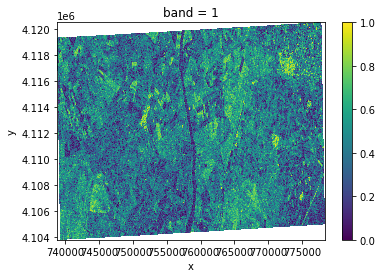

In [54]:
result[0].plot.imshow(vmin=0,vmax=1)